# Inference on Masked Images Using the Attention Model

This notebook performs inference using a pre-trained **Attention Model**, which leverages spatial and channel attention mechanisms, residual connections, and skip connections to reconstruct masked images. The results are visualized alongside the original images for comparison.

---
## Imports

In [50]:
import os
import torch
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import transforms

## Load Masked Images
We load all masked images from the `Reference_Images` directory. Each image is:

1. **Sorted** to ensure consistent order.
2. **Opened** using the `Pillow` library in RGB format.
3. Stored in a list for further processing.

The total number of images is printed at the end.


In [51]:
# Path to the Reference_Images directory
reference_images_dir = os.path.abspath(os.path.join("..", "Reference_Images"))

# Verify the directory exists
if not os.path.exists(reference_images_dir):
    raise FileNotFoundError(f"Reference Images directory not found: {reference_images_dir}")

# Load images from the directory
masked_images = []
masked_image_files = sorted(os.listdir(reference_images_dir))

for file_name in masked_image_files:
    image_path = os.path.join(reference_images_dir, file_name)
    if os.path.isfile(image_path):  # Ensure it's a file
        try:
            img = Image.open(image_path).convert("RGB")  # Open as PIL.Image
            masked_images.append(img)
        except Exception as e:
            print(f"Error loading file {file_name}: {e}")

print(f"Loaded {len(masked_images)} masked images for inference.")

Loaded 10 masked images for inference.


In [52]:
from torch import nn

class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super(ResidualBlock, self).__init__()
        self.block = nn.Sequential(
            nn.Conv2d(channels, channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(channels, channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(channels)
        )

    def forward(self, x):
        return x + self.block(x)  # Residual connection

class ChannelAttention(nn.Module):
    def __init__(self, channels, reduction=16):
        super(ChannelAttention, self).__init__()
        self.attention = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),  # Global average pooling
            nn.Conv2d(channels, channels // reduction, kernel_size=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(channels // reduction, channels, kernel_size=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        attention_weights = self.attention(x)
        return x * attention_weights

class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=7):
        super(SpatialAttention, self).__init__()
        self.attention = nn.Sequential(
            nn.Conv2d(2, 1, kernel_size=kernel_size, padding=(kernel_size // 2), bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        attention_input = torch.cat([avg_out, max_out], dim=1)
        attention_weights = self.attention(attention_input)
        return x * attention_weights

class ImageReconstructionModel(nn.Module):
    def __init__(self):
        super(ImageReconstructionModel, self).__init__()

        # Encoder
        self.encoder1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1),  # Downsample
            nn.ReLU(inplace=True),
            SpatialAttention(kernel_size=7),  # Add spatial attention
            nn.Dropout(0.2)  # Reduced dropout for regularization
        )
        self.encoder2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),  # Downsample
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            ChannelAttention(128),  # Add channel attention
            nn.Dropout(0.2)  # Reduced dropout for regularization
        )
        self.encoder3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),  # Downsample
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            ChannelAttention(256),  # Add channel attention
            nn.Dropout(0.2)  # Reduced dropout for regularization
        )

        # Bottleneck with Residual Blocks
        self.bottleneck = nn.Sequential(
            ResidualBlock(256),
            ResidualBlock(256),
            ResidualBlock(256)
        )

        # Decoder
        self.decoder1 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.PixelShuffle(upscale_factor=2),  # Replace transposed convolution
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            ResidualBlock(128),
            SpatialAttention(kernel_size=7)  # Add spatial attention
        )
        self.decoder2 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.PixelShuffle(upscale_factor=2),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            ResidualBlock(64),
            SpatialAttention(kernel_size=7)  # Add spatial attention
        )
        self.decoder3 = nn.Sequential(
            nn.Conv2d(64, 192, kernel_size=3, padding=1),
            nn.PixelShuffle(upscale_factor=2),  # Final upsample
            nn.Sigmoid()  # Normalize output to [0, 1]
        )

        # Skip connection layers with attention
        self.skip1 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=1),  # Align encoder1 channels with decoder2
            nn.BatchNorm2d(128),
            ChannelAttention(128),
            ResidualBlock(128)  # Add refinement
        )
        self.skip2 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=1),  # Align encoder2 channels with bottlenecked
            nn.BatchNorm2d(256),
            ChannelAttention(256),
            ResidualBlock(256)  # Add refinement
        )

        # Refinement layer for fine details
        self.refinement = nn.Sequential(
            nn.Conv2d(48, 64, kernel_size=3, padding=1),  # Adjust the input channels (48 in this case)
            nn.ReLU(inplace=True),
            ResidualBlock(64),
            ResidualBlock(64),  # Additional residual block for finer details
            nn.Conv2d(64, 3, kernel_size=3, padding=1),  # Final output with 3 channels
            nn.Sigmoid()  # Normalize output to [0, 1]
        )


    def forward(self, x):
        # Encode
        enc1 = self.encoder1(x)  # 64 channels
        enc2 = self.encoder2(enc1)  # 128 channels
        enc3 = self.encoder3(enc2)  # 256 channels

        # Bottleneck
        bottlenecked = self.bottleneck(enc3)

        # Decode with skip connections
        aligned_enc2 = nn.functional.interpolate(enc2, size=bottlenecked.shape[2:], mode="bilinear", align_corners=False)
        aligned_enc2 = self.skip2(aligned_enc2)  # Match channels to bottlenecked (256)

        dec1 = self.decoder1(bottlenecked + aligned_enc2)  # Combine bottleneck with encoder2 features

        aligned_enc1 = nn.functional.interpolate(enc1, size=dec1.shape[2:], mode="bilinear", align_corners=False)
        aligned_enc1 = self.skip1(aligned_enc1)  # Match channels to dec1 (128)

        dec2 = self.decoder2(dec1 + aligned_enc1)  # Combine decoder1 with encoder1 features

        # Final reconstruction
        dec3 = self.decoder3(dec2)

        # Refinement for fine details
        refined = self.refinement(dec3)

        return refined


# Instantiate Model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ImageReconstructionModel().to(device)

---
## Run Inference and Plot Results

1. **Model Path**: Specify the path to the saved model containing the trained weights.
2. **Inference**: The `run_inference_reconstruction` function processes the masked images, returning reconstructed images for each input.
3. **Visualization**:
   - Each **masked image** is displayed, with its corresponding **reconstructed image** shown directly below it.

This visualization allows for an intuitive assessment of the model's ability to reconstruct masked regions using attention mechanisms.


Model Path Resolved: ..\saved_models\AttentionModel\attention_model.pth


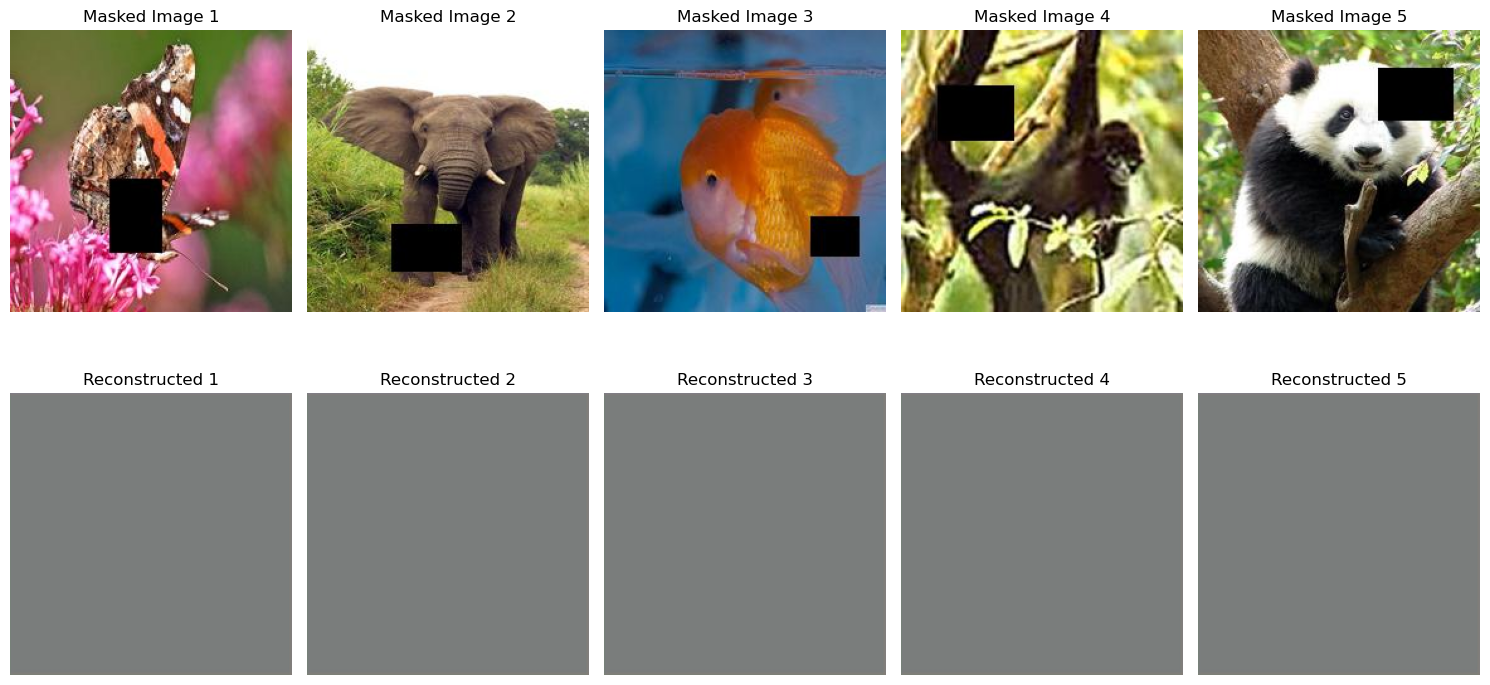

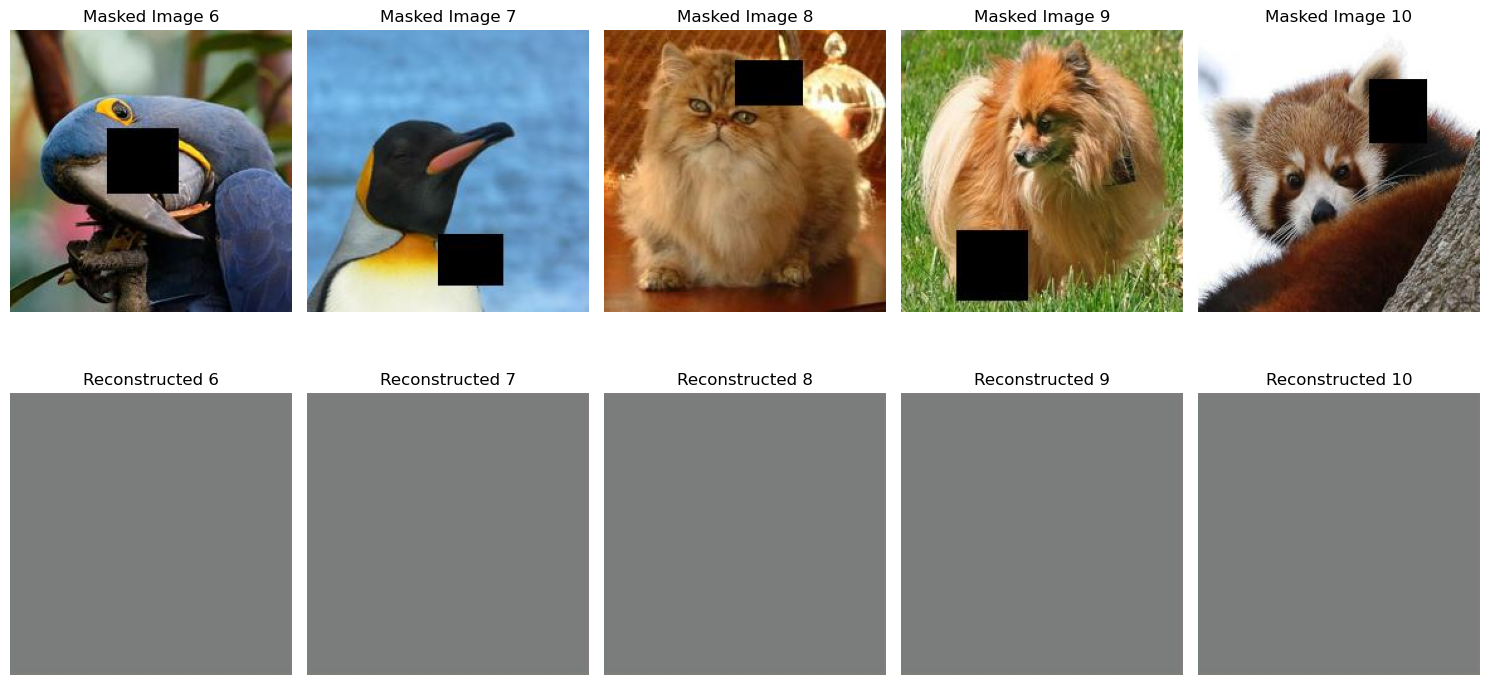

In [53]:
import os
import torch
from Inference_Funtion_Attention import load_images, run_inference  # Import necessary utilities
import matplotlib.pyplot as plt

# Path to the saved entire model
entire_model_path = os.path.join("..", "saved_models", "AttentionModel", "attention_model.pth")

# Verify that the model file exists
if not os.path.isfile(entire_model_path):
    raise FileNotFoundError(f"Entire model file not found: {entire_model_path}")
print(f"Model Path Resolved: {entire_model_path}")

# Load the entire model directly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = torch.load(entire_model_path, map_location=device)  # Load the full model

# print(model)

model.eval()  # Set the model to evaluation mode

# Load the reference images
reference_images_dir = os.path.abspath(os.path.join("..", "Reference_Images"))
masked_images = load_images(reference_images_dir)

# Run inference using the loaded model
results = run_inference(model, masked_images, device=device)

# Plot the original and reconstructed images
num_images = len(results)
fig, axs = plt.subplots(2, min(num_images, 5), figsize=(15, 8))

for i, reconstructed_image in enumerate(results):
    
    # Display masked images in the top row
    axs[0, i % 5].imshow(masked_images[i])
    axs[0, i % 5].axis("off")
    axs[0, i % 5].set_title(f"Masked Image {i + 1}")

    # Display reconstructed images in the bottom row
    axs[1, i % 5].imshow(reconstructed_image)
    axs[1, i % 5].axis("off")
    axs[1, i % 5].set_title(f"Reconstructed {i + 1}")

    # Handle plot layout after every 5 images
    if (i + 1) % 5 == 0 or i == num_images - 1:
        plt.tight_layout()
        plt.show()

        # Create new figure if more images remain
        if i != num_images - 1:
            fig, axs = plt.subplots(2, min(num_images - i - 1, 5), figsize=(15, 8))

plt.show()
